In [1]:
library(lme4)
library(afex)
library(emmeans)
library(dplyr)
library(ggplot2)
library(svglite)
library(lmtest)
library(tidyr)
library(MCMCglmm)
library(reshape)
library(gridExtra)
library(cowplot)
library(svglite)
library(data.table)

Loading required package: Matrix

************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- Get and set global package options with: afex_options()
- Set sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************


Attaching package: ‘afex’


The following object is masked from ‘package:lme4’:

    lmer



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘tidyr’


The following objects 

In [2]:
ITI <- read.csv('/home/bagotlab/eshaan.i/PRL/FP_PRL_Nov_2021/Code/Longform Data/CondensedPRL_ZScore_ITI.csv')
ITI = subset(ITI,ID!=223)
ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<-ITI[,c('index','time_idx','time','ID','rewards','lp','Day','rt','PFC','vHIP')]
ITI$sex <- as.factor(ifelse(ITI$ID > 212,"Female", "Male"))
ITI$Day <- as.numeric(as.factor(ITI$Day))

Behavior<- ITI %>% group_by(index)%>%summarize(rewards=mean(rewards),ID=mean(ID),rt=mean(rt),lp=mean(lp), Day=mean(Day))
Behavior$TrialType <- as.factor(ifelse(Behavior$rewards==1, 'Rewards', ifelse(Behavior$lp==0, 'Omission', 'Unrewarded')))
Behavior$sex <- as.factor(ifelse(Behavior$ID > 212,"Female", "Male"))

ITI = subset(ITI, lp > 0)
ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Previous.Reward = lag(rewards,n=240))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Previous.Previous.Reward = lag(Previous.Reward,n=240))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Next.Choice = lead(lp,n=240))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Next.RT = lead(rt,n=240))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Previous.Choice = lag(lp,n=240))
ITI$Stay <- ifelse(ITI$lp == ITI$Previous.Choice,1,0)
ITI$StayNext <- ifelse(ITI$lp == ITI$Next.Choice,1,0)

enditi<- as.data.frame(ITI[((ITI$time)>=8)&((ITI$time)<=10),] %>% 
                group_by(index)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),rewards=mean(rewards),ID=mean(ID),Previous.Reward=mean(Previous.Reward), Previous.Previous.Reward=mean(Previous.Previous.Reward),Stay=mean(Stay), StayNext=mean(StayNext), lp=mean(lp),Day=mean(Day), PFCend=mean(PFC),vHIPend=mean(vHIP)))
Post_DF <- as.data.frame(ITI[((ITI$time)>=0)&((ITI$time)<=2),] %>% group_by(index)%>%summarize(PFC_Post=mean(PFC),vHIP_Post=mean(vHIP)))
Pre_DF <- as.data.frame(ITI[((ITI$time)>=-2)&((ITI$time)<0),] %>% group_by(index)%>%summarize(PFC_Pre=mean(PFC),vHIP_Pre=mean(vHIP)))

DF <- merge(enditi, Post_DF)
DF <- merge(DF, Pre_DF)
DF$sex <- as.factor(ifelse(DF$ID > 212,"Female", "Male"))
DF$ID<-as.factor(DF$ID)
DF$Day<-as.factor(DF$Day)
DF$rewards <- as.factor(ifelse(DF$rewards == 0,"Unrewarded", "Rewarded"))
DF$Previous.Reward <- as.factor(ifelse(DF$Previous.Reward == 0,"Unrewarded", "Rewarded"))
DF$Stay <- as.factor(ifelse(DF$Stay == 0,"Shift", "Stay"))
DF$lp <- as.factor(ifelse(DF$lp == 1,"Contralateral", "Ipsilateral"))

ITI$rewards<-as.factor(ITI$rewards)
ITI$ID<-as.factor(ITI$ID)
ITI$Day<-as.factor(ITI$Day)
ITI$Previous.Reward <-as.factor(ITI$Previous.Reward)
ITI$rewards <- as.factor(ifelse(ITI$rewards == 0,"Unrewarded", "Rewarded"))
ITI$Stay <- as.factor(ifelse(ITI$Stay == 0,"Shift", "Stay"))
ITI$lp <- as.factor(ifelse(ITI$lp == 1,"Contralateral", "Ipsilateral"))


In [5]:
plot_theme <- theme(axis.title=element_text(size=25,color='gray30'),
                    axis.line=element_line(color='gray30'),
                    axis.text.y=element_text(size=20,color='gray30'),
                    axis.text.x=element_text(size=20,color='gray30'),
                    legend.text=element_text(size=20),
                    legend.key.size=unit(2,'mm'),
                    panel.background=element_blank(),
                    panel.grid.major.y = element_blank(),
                    legend.position = 'none',
                    plot.margin = margin(0.5,0.5,0.5,0.5,'cm'),
                    strip.background = element_blank(),
                    strip.text = element_text(size=20,color='gray30')) 

plot_theme_PFC <- list(plot_theme, 
                        scale_color_manual(values=c('Rewarded'="#B51D1D",  'Unrewarded'="#444444",'Stay'="#791bfa", 'Shift'="#ad74fb" )),
                        scale_fill_manual(values=c('Rewarded'="#B51D1D",  'Unrewarded'="#444444", 'Stay'="#791bfa", 'Shift'="#ad74fb")),
                        scale_shape_manual(values=c('Male'=16,'Female'=17)))
plot_theme_vHIP <- list(plot_theme, 
                        scale_color_manual(values=c('Rewarded'="#F27E19", 'Unrewarded'="#444444",'Stay'="#000bfa", 'Shift'="#787ef9")), 
                        scale_fill_manual(values=c('Rewarded'="#F27E19", 'Unrewarded'="#444444",'Stay'="#000bfa", 'Shift'="#787ef9")),
                        scale_shape_manual(values=c('Male'=16,'Female'=17)))

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 29320' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 29320)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 29320' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 29320)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: PFC ~ rewards * sex + (1 | Day) + (1 | ID)
   Data: DF

REML criterion at convergence: 54513.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4416 -0.5802 -0.0731  0.5229  8.9100 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.003463 0.05885 
 Day      (Intercept) 0.001046 0.03234 
 Residual             0.374665 0.61210 
Number of obs: 29320, groups:  ID, 21; Day, 6

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -1.650e-01  2.401e-02  2.292e+01  -6.873 5.33e-07 ***
rewardsUnrewarded          2.174e-01  1.018e-02  2.930e+04  21.348  < 2e-16 ***
sexMale                   -1.170e-02  2.781e-02  2.225e+01  -0.421    0.678    
rewardsUnrewarded:sexMale -1.587e-02  1.442e-02  2.931e+04  -1.100    0.271    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

C

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,sex,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Rewarded - Unrewarded,Female,-0.2173751,0.01018224,Inf,-21.34846,0
2,Rewarded - Unrewarded,Male,-0.2015072,0.01026787,Inf,-19.62502,0
,contrast,rewards,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Female - Male,Rewarded,0.01169928,0.02781350,Inf,0.4206333,0.8937389
2,Female - Male,Unrewarded,0.02756722,0.02752906,Inf,1.0013860,0.5330194


sex = Female:
 rewards     emmean     SE  df asymp.LCL asymp.UCL
 Rewarded   -0.1650 0.0240 Inf  -0.21209   -0.1180
 Unrewarded  0.0523 0.0238 Inf   0.00561    0.0991

sex = Male:
 rewards     emmean     SE  df asymp.LCL asymp.UCL
 Rewarded   -0.1767 0.0234 Inf  -0.22258   -0.1309
 Unrewarded  0.0248 0.0232 Inf  -0.02068    0.0702

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

`summarise()` has grouped output by 'ID', 'sex'. You can override using the
`.groups` argument.
Warning message:
“Removed 2 rows containing missing values (geom_point).”


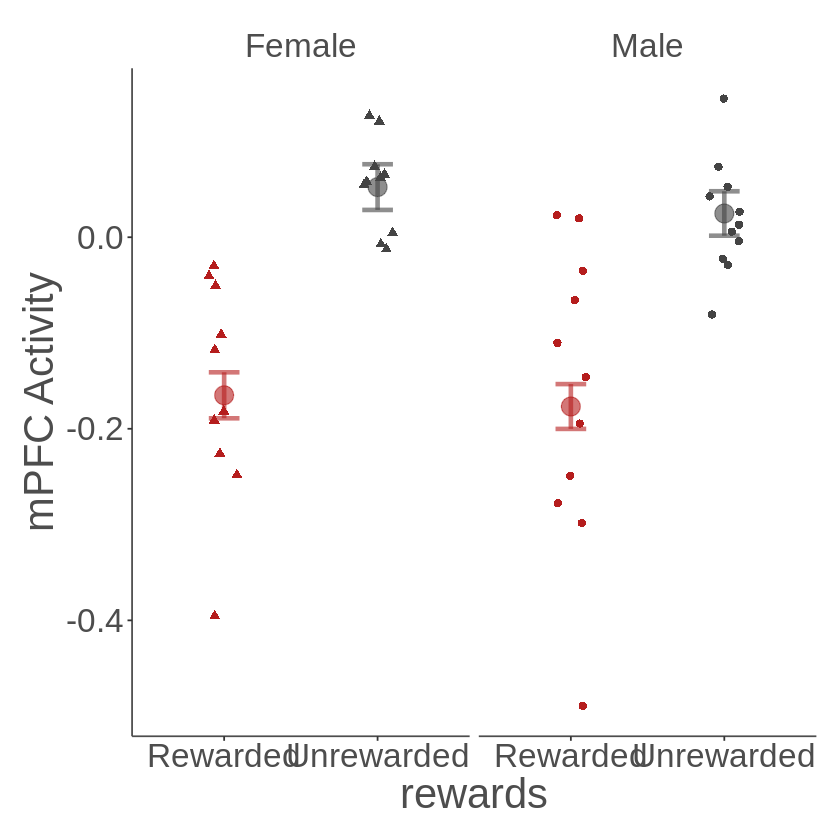

In [12]:
#Plot mPFC-NAc traces

PFC1Back = NULL
for (tm in 1:240){
myModel=lmer(PFC ~ rewards*sex +(1|ID)+(1|Day),data=subset(ITI, (time_idx==tm)))
current_time = mean(subset(ITI, (time_idx==tm))$time)
PFC1Back= rbind(PFC1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ rewards|sex))))
}

#Quantify mPFC-NAc end of ITI

PFC_rewards_enditi <- lmer(PFC~rewards*sex+(1|Day)+(1|ID), REML=TRUE ,data = DF)
PFC_rewards_enditi_means <- emmeans(PFC_rewards_enditi, ~ rewards|sex)

summary(PFC_rewards_enditi)
dtf <- PFC_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
dtf

Bulk <- DF %>% group_by(ID,sex, rewards) %>% summarise(PFC=mean(PFC, na.rm = TRUE))

ggplot(data = PFC1Back)+
  geom_line(aes(time,emmean,group=rewards, colour=rewards))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = rewards), alpha = .2)+
  xlab('Time from LP')+
  ylab('mPFC Activity')+
  geom_vline(xintercept=0, linetype="dotted", size = 1)+
  plot_theme_PFC+
  facet_grid(~sex)

dtf<- data.frame(dtf)
dtf$SE <- dtf$SE * sign(dtf$emmean)
ggplot(data.frame(dtf)) +
  geom_point( aes(x=rewards, y=emmean, color=rewards), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=rewards, ymin=emmean-SE, ymax=emmean+SE,color=rewards), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = rewards, y = PFC, color = rewards, shape=sex), size = 2, width = 0.1) +
  ylab('mPFC Activity')+
  plot_theme_PFC + 
  facet_grid(~sex)


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 30789' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 30789)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 30789' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 30789)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: vHIP ~ rewards * sex + (1 | Day) + (1 | ID)
   Data: DF

REML criterion at convergence: 56889.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8279 -0.5796 -0.0732  0.5135  7.5059 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 0.0011880 0.03447 
 Day      (Intercept) 0.0002272 0.01507 
 Residual             0.3706864 0.60884 
Number of obs: 30789, groups:  ID, 22; Day, 6

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -8.845e-02  1.455e-02  2.792e+01  -6.077 1.50e-06 ***
rewardsUnrewarded          8.259e-02  1.012e-02  3.058e+04   8.161 3.44e-16 ***
sexMale                    2.269e-02  1.798e-02  2.883e+01   1.262    0.217    
rewardsUnrewarded:sexMale  4.073e-03  1.400e-02  3.069e+04   0.291    0.771    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,sex,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Rewarded - Unrewarded,Female,-0.08259171,0.010120028,Inf,-8.161214,6.661338e-16
2,Rewarded - Unrewarded,Male,-0.08666436,0.009711047,Inf,-8.924306,0.000000e+00
,contrast,rewards,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Female - Male,Rewarded,-0.02268849,0.01798206,Inf,-1.261729,0.3712242
2,Female - Male,Unrewarded,-0.02676114,0.01757766,Inf,-1.522452,0.2394344


sex = Female:
 rewards      emmean     SE  df asymp.LCL asymp.UCL
 Rewarded   -0.08845 0.0146 Inf  -0.11697   -0.0599
 Unrewarded -0.00586 0.0143 Inf  -0.03386    0.0221

sex = Male:
 rewards      emmean     SE  df asymp.LCL asymp.UCL
 Rewarded   -0.06576 0.0137 Inf  -0.09267   -0.0389
 Unrewarded  0.02090 0.0134 Inf  -0.00543    0.0472

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

`summarise()` has grouped output by 'ID', 'sex'. You can override using the
`.groups` argument.


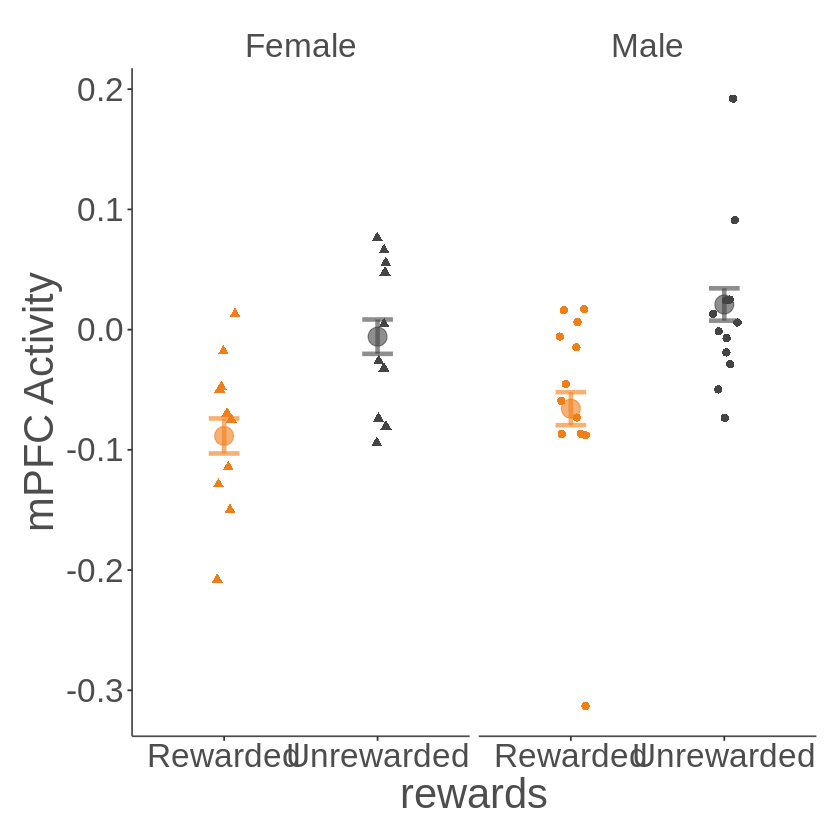

In [13]:
#Plot vHip-NAc traces

vHIP1Back = NULL
for (tm in 1:240){
myModel=lmer(vHIP ~ rewards*sex +(1|ID)+(1|Day),data=subset(ITI, (time_idx==tm)))
current_time = mean(subset(ITI, (time_idx==tm))$time)
vHIP1Back= rbind(vHIP1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ rewards|sex))))
}

#Quantify vHip-NAc end of ITI

vHIP_rewards_enditi <- lmer(vHIP~rewards*sex+(1|Day)+(1|ID), REML=TRUE ,data = DF)
vHIP_rewards_enditi_means <- emmeans(vHIP_rewards_enditi, ~ rewards|sex)

summary(vHIP_rewards_enditi)
dtf <- vHIP_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
dtf

Bulk <- DF %>% group_by(ID,sex, rewards) %>% summarise(vHIP=mean(vHIP, na.rm = TRUE))

ggplot(data = vHIP1Back)+
  geom_line(aes(time,emmean,group=rewards, colour=rewards))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = rewards), alpha = .2)+
  xlab('Time from LP')+
  ylab('vHip Activity')+
  geom_vline(xintercept=0, linetype="dotted", size = 1)+
  plot_theme_vHIP+
  facet_grid(~sex)

dtf<- data.frame(dtf)
dtf$SE <- dtf$SE * sign(dtf$emmean)
ggplot(data.frame(dtf)) +
  geom_point( aes(x=rewards, y=emmean, color=rewards), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=rewards, ymin=emmean-SE, ymax=emmean+SE,color=rewards), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = rewards, y = vHIP, color = rewards, shape=sex), size = 2, width = 0.1) +
  ylab('mPFC Activity')+
  plot_theme_vHIP + 
  facet_grid(~sex)


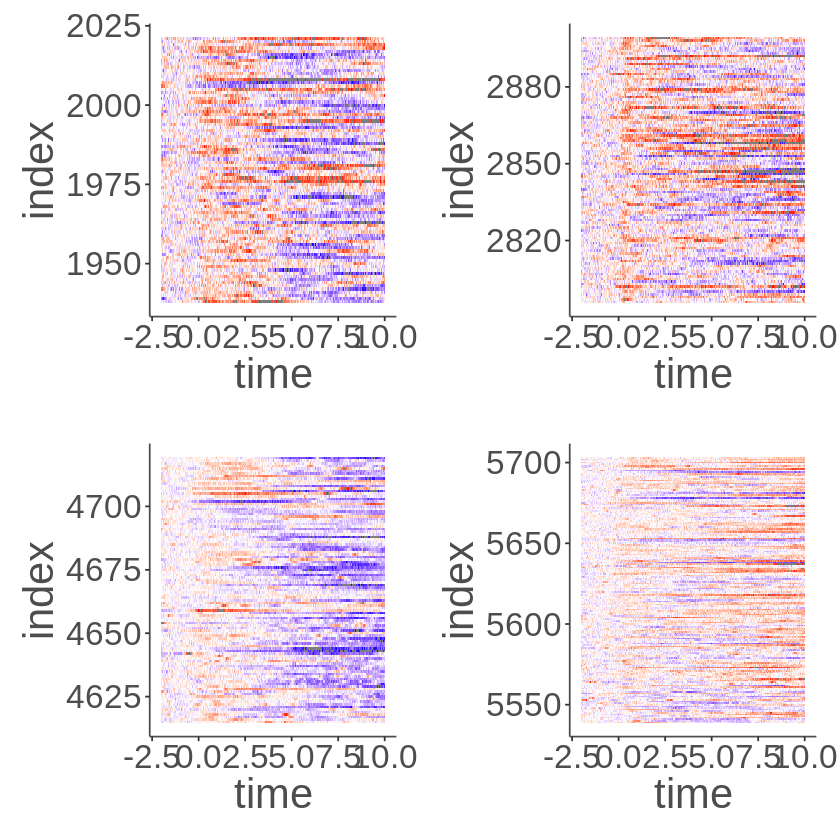

In [14]:
#Plot heatmaps

heatmap = merge(ITI,DF[c('index','PFC_Pre', 'vHIP_Pre','PFCend', 'vHIPend')],by = 'index')
heatmap$PFC = heatmap$PFC - heatmap$PFC_Pre
heatmap$vHIP = heatmap$vHIP - heatmap$vHIP_Pre
heatmap$index <- as.numeric(as.factor(heatmap$index))
Unrewarded = subset(heatmap, rewards=='Unrewarded')
Unrewarded$index <- as.numeric(as.factor(Unrewarded$index))
Rewarded = subset(heatmap, rewards=='Rewarded')
Rewarded$index <- as.numeric(as.factor(Rewarded$index))

PFCRewarded<-ggplot(data = subset(Rewarded, (ID==204)&(Day==3)), mapping = aes(x = time,y = index,fill = PFC)) +
    geom_tile() +
    scale_fill_gradient2(limits=range(-2,2), midpoint = 0, low="blue", mid = "white", high = "red") +
    plot_theme
PFCUnrewarded<-ggplot(data = subset(Unrewarded, (ID==204)&(Day==3)), mapping = aes(x = time,y = index,fill = PFC)) +
    geom_tile() +
    scale_fill_gradient2(limits=range(-2,2), midpoint = 0, low="blue", mid = "white", high = "red")+
    plot_theme
vHIPRewarded<-ggplot(data = subset(Rewarded, (ID==208)&(Day==2)), mapping = aes(x = time,y = index,fill = vHIP)) +
    geom_tile() +
    scale_fill_gradient2(limits=range(-2,2), midpoint = 0, low="blue", mid = "white", high = "red")+
    plot_theme
vHIPUnrewarded<-ggplot(data = subset(Unrewarded, (ID==208)&(Day==2)), mapping = aes(x = time,y = index,fill = vHIP)) +
    geom_tile() +
    scale_fill_gradient2(limits=range(-2,2), midpoint = 0, low="blue", mid = "white", high = "red")+
    plot_theme

grid.arrange(PFCRewarded,PFCUnrewarded,vHIPRewarded,vHIPUnrewarded)